## Attention is All You Need 실습

![](assets/transformer1.png)
* 본 코드는 [Attention is All You Need](https://arxiv.org/abs/1706.03762) 논문을 최대한 따릅니다.
* https://github.com/bentrevett/pytorch-seq2seq 를 참조하여 작성 되었습니다.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# Multi30k - 대표적인 영어-독어 번역 데이터셋(dataset)
from torchtext.legacy.datasets import Multi30k 
# Field - 데이터 전처리를 위한 조건 설정(tokenizing)
#BucketIterator - 각각의 새로운 epoch에 대해 데이터 random shiffle
#한 batch에 비슷한 길이의 문장들이 들어가도록하는 iterator(padding의 양을 최소화)
from torchtext.legacy.data import Field, BucketIterator 


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# spacy - 문장의 토큰화 태깅과 같은 전처리 기능을 위한 라이브러리
import spacy 
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

* spacy 라이브러리: 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리  
 * 영어(Engilsh)와 독일어(Deutsch) tokenizer 정의  
spacy_de = https://spacy.io/models/de#de_core_news_md (news, media)  
spacy_en = https://spacy.io/models/en#en_core_web_sm (blogs, news, comments)

In [3]:
# Load German,English tokenizer, tagger, parser and NER
spacy_de = spacy.load('de_core_news_sm') # 독일어 토큰화(tokenization)
spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization) 

* 영어(English) 및 독일어 토큰화 함수 정의

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
#spacy tokenizer testing
# 간단히 토큰화(tokenization) 기능 써보기 (입력 텍스트를 영어 토큰으로 분리)
tokenized = spacy_en.tokenizer("I am a graduate student.")
print(tokenized)
for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

I am a graduate student.
인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .


#### torchtext.Field()
* 데이터셋에 대한 구체적인 전처리 내용을 명시한 필드(field) 객체 생성
* batch_fisrt = [Batch_size, Seq_len, Hidden_size] 형태로 feed 하기 위해 True로 설정
* 번역 목표
    * SRC(소스) : 독일어
    * 목표(TRG) : 영어

In [6]:
SRC = Field(tokenize = tokenize_de, #spacy tokenizer를 사용하는 tokenizer function
            init_token = '<sos>', #문장 시작에 삽입할 토큰 Default: None 
            eos_token = '<eos>', #문장 끝에 삽입할 토큰 Default: None
            lower = True, #텍스트를 소문자로 할지 여부
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

#### Multi30k.splits() 
* 대표적인 영어-독어 번역 데이터셋인 Multi30k를 불러온다.

Create dataset objects for splits of the Multi30k dataset.  
Parameters:	
* exts – A tuple containing the extension to path for each language.  
* fields – A tuple containing the fields that will be used for data in each language.  
* root – Root dataset storage directory. Default is ‘.data’.
* train – The prefix of the train data. Default: ‘train’.
* validation – The prefix of the validation data. Default: ‘val’.
* test – The prefix of the test data. Default: ‘test’.
* keyword arguments (Remaining) – Passed to the splits method of Dataset.

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [8]:
#testing
print(f"학습 데이터셋(training dataset) 크기: {len(train_data.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_data.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_data.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [9]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_data.examples[30])['src'])
print(vars(train_data.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


* 필드(field) 객체의 build_vocab 메서드를 이용해 영어와 독어의 단어 사전을 생성한다.  
    * 최소 2번 이상 등장한 단어만을 선택

In [10]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
#testing
print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7853
len(TRG): 5893


In [11]:
#testing
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


* 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 합니다.
    * 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋습니다.
    * 이를 위해 BucketIterator를 사용합니다.
    * 배치 크기(batch size): 128

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

In [13]:
#train_iterator testing
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    print(src)
    break

tensor([[   2,    8,   16,  ...,    1,    1,    1],
        [   2,   54, 1551,  ...,    1,    1,    1],
        [   2,    5,  717,  ...,    1,    1,    1],
        ...,
        [   2,    8,   36,  ...,    1,    1,    1],
        [   2,    5,   13,  ...,    1,    1,    1],
        [   2,    5,   13,  ...,    1,    1,    1]], device='cuda:0')


In [14]:
#train_iterator testing
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    print("src 인덱스 정보")
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]
    print("\ntrg 인덱스 정보")
    for i in range(trg.shape[1]):
        print(f"인덱스 {i}: {trg[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]
    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 33])
src 인덱스 정보
인덱스 0: 2
인덱스 1: 8
인덱스 2: 67
인덱스 3: 217
인덱스 4: 12
인덱스 5: 33
인덱스 6: 214
인덱스 7: 9
인덱스 8: 35
인덱스 9: 17
인덱스 10: 101
인덱스 11: 17
인덱스 12: 998
인덱스 13: 20
인덱스 14: 1784
인덱스 15: 93
인덱스 16: 4
인덱스 17: 3
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1

trg 인덱스 정보
인덱스 0: 2
인덱스 1: 4
인덱스 2: 64
인덱스 3: 3177
인덱스 4: 7
인덱스 5: 166
인덱스 6: 28
인덱스 7: 82
인덱스 8: 4061
인덱스 9: 8
인덱스 10: 421
인덱스 11: 5
인덱스 12: 3
인덱스 13: 1
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1
인덱스 33: 1
인덱스 34: 1


### 인코더(Encoder) 아키텍처

![](assets/transformer-encoder.png)

* 전체 인코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * input_dim: 하나의 단어에 대한 원 핫 인코딩 차원(input vocab size)
    * hidden_dim: 하나의 단어에 대한 임베딩 차원
    * n_layers: 내부적으로 사용할 인코더 레이어의 개수
    * n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    * dropout_ratio: 드롭아웃(dropout) 비율
    * max_length: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 위치 임베딩(positional embedding)을 학습하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* < pad > 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim) # word embedding
        self.pos_embedding = nn.Embedding(max_length, hid_dim) # positional embedding
        
        #encoder(slef attentino, residual connection, layer normalization, FFNN) 쌓기
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)]) 
        
        self.dropout = nn.Dropout(dropout) 
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device) #데이터의 분산을 줄이기 위한 scaling factor로 추정
        
    def forward(self, src, src_mask):
        
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1] 
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # pos = [batch size, src len] : position
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        # src = [batch size, src len, hid dim] : tocken embedding + positional embedding
        # src_mask = padding masking
        
        for layer in self.layers:
            src = layer(src, src_mask) 
            
        #src = [batch size, src len, hid dim]
            
        return src

### 인코더(Encoder) 레이어 아키텍처
* 하나의 인코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용합니다.
* 하이퍼 파라미터(hyperparameter)
    * hidden_dim: 하나의 단어에 대한 임베딩 차원
    * n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    * dropout_ratio: 드롭아웃(dropout) 비율
* <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention - 입력 문장 내에 있는 단어들 간의 연관성계산
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Multi Head Attention 아키텍처

![](assets/transformer-attention.png)
$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$
* 어텐션(attention)은 세 가지 요소를 입력으로 받습니다.
    * 쿼리(queries) - 내적(유사도)을 구할 단어
    * 키(keys) - 쿼리(queries) 단어와 내적(유사도)를 구할 단어들
    * 값(values) - 쿼리(queries)와 키(keys) 간의 유사도가 적용된 단어 벡터들 (weighted sum)
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * hidden_dim: 하나의 단어에 대한 임베딩 차원
    * n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * dropout_ratio: 드롭아웃(dropout) 비율

In [17]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim) # encoder 입력으로부터 query matrix를 얻을 weight matrix
        self.fc_k = nn.Linear(hid_dim, hid_dim) # encoder 입력으로부터 key matrix를 얻을 weight matrix
        self.fc_v = nn.Linear(hid_dim, hid_dim) # encoder 입력으로부터 vlaue matrix를 얻을 weight matrix
        
        self.fc_o = nn.Linear(hid_dim, hid_dim) # encoder의 FFNN입력을 생성하기 위한 wegith matrix
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # transpose K
        #Q = [batch size, n heads, query len, head dim] 
        #K = [batch size, n heads, head dim, key len] 
        #energy = [batch size, n heads, query len, key len] 
        
        if mask is not None: #src_mask = [batch size, 1, 1, src len] < PAD >와 < PAD >간에 유사도 무시
            # encoder : padding maxk, decoder : padding maxk + look-ahead mask
            energy = energy.masked_fill(mask == 0, -1e10) 
        
        attention = torch.softmax(energy, dim = -1) # 가장 마지막 차원(각 단어에대한 attention score)의 어텐션 분포 구하기
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V) #V 와 weighted sum 하여 (attention value)context vector 구하기
        
        #x = [batch size, n heads, query len, head dim] 각각의 row는 query에 해당하는 단어와 모든단어간의 가중합된 vector
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward 아키텍처
* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터(hyperparameter)
    * hidden_dim: 하나의 단어에 대한 임베딩 차원
    * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    * dropout_ratio: 드롭아웃(dropout) 비율

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### 디코더(Decoder) 아키텍처

![](assets/transformer-decoder.png)

* 전체 디코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * output_dim: 하나의 단어에 대한 원 핫 인코딩 차원(output vocab size)
    * hidden_dim: 하나의 단어에 대한 임베딩 차원
    * n_layers: 내부적으로 사용할 인코더 레이어의 개수
    * n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    * dropout_ratio: 드롭아웃(dropout) 비율
    * max_length: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 위치 임베딩(positional embedding)을 학습하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* Seq2Seq과 마찬가지로 실제로 추론(inference) 시기에서는 디코더 입력을 반복적으로 넣을 필요가 있습니다.
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.
* 소스 문장의 < pad > 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        # trg = [batch size, trg len, hid dim] : tocken embedding + positional embedding

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask) #enc_src, src_mask 차이
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### 디코더(Decoder) 레이어 아키텍처
* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용합니다.
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어가 사용됩니다.
* 하이퍼 파라미터(hyperparameter)
    * hidden_dim: 하나의 단어에 대한 임베딩 차원
    * n_heads: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
    * dropout_ratio: 드롭아웃(dropout) 비율
* 소스 문장의 < pad > 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim] : encoder final output
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention : masked self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask) #trg_mask - < PAD > mask, look-ahead mask
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask) #src_mask - <PAD> mask
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        # trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### 트랜스포머(Transformer) 아키텍처
* 최종적인 전체 트랜스포머(Transformer) 모델을 정의합니다.
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성합니다.

`torch.tril` - look-ahead mask 생성에 사용되는 torch 메서드  
  
example - `torch.tril(torch.ones((5, 5)))`
$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

In [21]:
class transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool() #boolean tensor로 변환
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask # <PAD>mask + look-ahead mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

### 학습(Training)
* 하이퍼 파라미터 설정 및 모델 초기화
* encoder와 decoder 정의

In [22]:
INPUT_DIM = len(SRC.vocab) # source의 vocab 개수
OUTPUT_DIM = len(TRG.vocab) # target의 vocab 개수
HID_DIM = 256 # 인코더 디코더의 hidden dimension
ENC_LAYERS = 3 # 인코더의 layer 개수
DEC_LAYERS = 3 # 디코더의 layer 개수
ENC_HEADS = 8 # 인코더의 attention 해드의 갯수 ( scaled dot product attention 연산 횟수 )
DEC_HEADS = 8 # 디코더의 attention 해드의 갯수 ( scaled dot product attention 연산 횟수 )
ENC_PF_DIM = 512 # 인코더의 position wied FFNN의 차원수
DEC_PF_DIM = 512 # 디코더의 position wied FFNN의 차원수
ENC_DROPOUT = 0.1 # 인코더의 dropout rate
DEC_DROPOUT = 0.1 # 디코더의 dropout rate

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [23]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token] # SRC_PAD_IDX = 1
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token] # TRG_PAD_IDX = 1

model = transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [24]:
def count_parameters(model):
    # requires_grad : parameter 에 기울기가 필요한 경우 True, 즉 학습 가능한 paramerter라는 의미
    # torch.numel() : Returns the total number of elements in the tensor.
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


* 모델 파라미터 초기화(xavier)
    * gradient의 소실이나 폭발을 방지 하고 안정적인 gradient를 얻기 위함 

In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        

In [26]:
#nn.module.apply(fn) fn은 모든 하위모듈과 self로 정의된 parameter에 적용된다.
#일반적으로 모델의 매개변수 초기화의 용도로 사용
model.apply(initialize_weights); 

* 학습 및 평가 함수 정의
    * 추론 단계에서는 기본적인 seq2seq모델과 유사

In [27]:
LEARNING_RATE = 0.0005
# Adam optimizer로 학습 최적화
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
# 뒷 부분의 패딩(padding)에 대해서는 값 무시
# [0, C]까지의 class index가 있을때(vocab index) <pad> index에 대해서는 loss계산에 포함되지 않도록 한다.
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [28]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src # [sos, x1, x2, ..., xn, eos, pad, pad]
        trg = batch.trg # [sos, x1, x2, ..., xm, eos, pad, pad]
        optimizer.zero_grad()
        
        #trg[:,:-1] 마지막pad 토큰을 예측해야 하므로 제외 [sos, X1, x2, ..., xm, eos, pad] 
        #outout = [y1, y2, ... ym, ...,eos, pad, pad]
        output, _ = model(src, trg[:,:-1]) # output, attention(decoder의 최종 encoder-decoder attention값)
        
        #output = [batch size, trg len - 1, output dim] #<sos>토큰 이후부터 예측을 시작하므로
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        
        # 모든 배치에 대해서 loss를 계산하기 위한 view()
        # transformer 연산으로 contiguous가 깨졌으므로 contiguous() 수행
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1) #trg[:,1:] <sos>토큰은 처음 입력으로 주어지는 값이므로 제외
                
        #output = [batch size * trg len - 1, output dim] <sos>토큰을 제외하고 예측
        #trg = [batch size * trg len - 1] <sos>토큰 제외
        
        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        # 기울기(gradient) 계산
        loss.backward()
        
        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # 파라미터 업데이트
        optimizer.step()
        
        #epoch전체 손실값 계산
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    
    model.eval()# 평가 모드
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            # 모든 배치에 대해서 loss를 계산하기 위한 view()
            # transformer 연산으로 contiguous가 깨졌으므로 contiguous() 수행
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1) #trg[:,1:] <sos>토큰은 처음 입력으로 주어지는 값이므로 제외
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)
            
            #epoch전체 손실값 계산
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

* 학습(training) 및 검증(validation) 진행
    * 학습 횟수(epoch): 10

In [31]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #validation loss가 가장 작은 모델 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 13s
	Train Loss: 4.230 | Train PPL:  68.748
	 Val. Loss: 3.027 |  Val. PPL:  20.637
Epoch: 02 | Time: 0m 13s
	Train Loss: 2.822 | Train PPL:  16.817
	 Val. Loss: 2.298 |  Val. PPL:   9.954
Epoch: 03 | Time: 0m 13s
	Train Loss: 2.241 | Train PPL:   9.400
	 Val. Loss: 1.981 |  Val. PPL:   7.248
Epoch: 04 | Time: 0m 13s
	Train Loss: 1.890 | Train PPL:   6.617
	 Val. Loss: 1.799 |  Val. PPL:   6.043
Epoch: 05 | Time: 0m 13s
	Train Loss: 1.644 | Train PPL:   5.174
	 Val. Loss: 1.711 |  Val. PPL:   5.536
Epoch: 06 | Time: 0m 13s
	Train Loss: 1.455 | Train PPL:   4.284
	 Val. Loss: 1.647 |  Val. PPL:   5.192
Epoch: 07 | Time: 0m 13s
	Train Loss: 1.304 | Train PPL:   3.685
	 Val. Loss: 1.623 |  Val. PPL:   5.070
Epoch: 08 | Time: 0m 13s
	Train Loss: 1.181 | Train PPL:   3.258
	 Val. Loss: 1.602 |  Val. PPL:   4.961
Epoch: 09 | Time: 0m 13s
	Train Loss: 1.071 | Train PPL:   2.919
	 Val. Loss: 1.614 |  Val. PPL:   5.024
Epoch: 10 | Time: 0m 13s
	Train Loss: 0.975 | Train PPL

In [32]:
model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.665 | Test PPL:   5.285 |


### Inference

* 테스트 데이터셋을 이요해 모델 테스트 진행
* 모델 테스트를 위한 번역 함수 정의

In [33]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval() # 평가 모드
    
    #tokenize가 되지 않은 sentance라면
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    #tokenize된 list 라면
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    #torchtext.vocab stoi – 토큰 문자열을 숫자 식별자에 매핑하는 collections.defaultdict 인스턴스.
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # src_indexes - [seq_len]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    # src_tensor - [1 num_sentence(batch_size), seq_len]

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)
    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        # src_tensor - [1 num_data(batch_size), seq_len]

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        #output = [batch size, trg len, output dim]
        
        output.argmax(2) #[1 num_sentence(batch size), len(trg_tensor)]
       
        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        
        # trg_indexes에 예측 토큰 인덱스 추가
        trg_indexes.append(pred_token)
        
        # <eos>를 만나는 순간 끝 string_to_index
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    # 각 출력 단어 인덱스를 실제 단어로 변환 index to string
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

* 어텐션 가중치(Attention weight) 시각화 함수
    * 디코더의 encoder-decoer attention의 attention weight시각화

In [34]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    #matplotlib figure object생성
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):
        
        #matplotlib Subplot 생성
        ax = fig.add_subplot(n_rows, n_cols, i+1)

        # attention = [1, num_head, len_src, len_trg] 
        # attention score를 soft_max함수를 거쳐 구한 attention_distribution(attnetion_weight)
        # detach()는 이 연산 기록(graph)으로 부터 분리한 tensor을 반환
        # .cpu() GPU 메모리에 올려져 있는 tensor를 cpu 메모리로 복사하는 method
        _attention = attention.squeeze(0)[i].detach().cpu().numpy()
        #_attention = [len_src, len_trg]
        
        #attention distribution(attention weight)시각화
        #AxesSubplot.matshow - Plot the values of a 2D matrix or array as color-coded image.
        cax = ax.matshow(_attention, cmap='bone')
        
        # figure.colorbar - Add a colorbar to a plot
        fig.colorbar(cax)
        ax.tick_params(labelsize=12) #label 크기 조절
        #앞에 빈공간이 있어야함 <sos>토큰과 <eos>토큰은 전처리(Field) 후에 붙음
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) #1의 간격으로 label을 배치
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1)) #1의 간격으로 label을 배치

    plt.show() # Display all open figures.
    plt.close() # Close a figure window.

In [35]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [36]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


/tmp/ipykernel_23809/3519639228.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_23809/3519639228.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


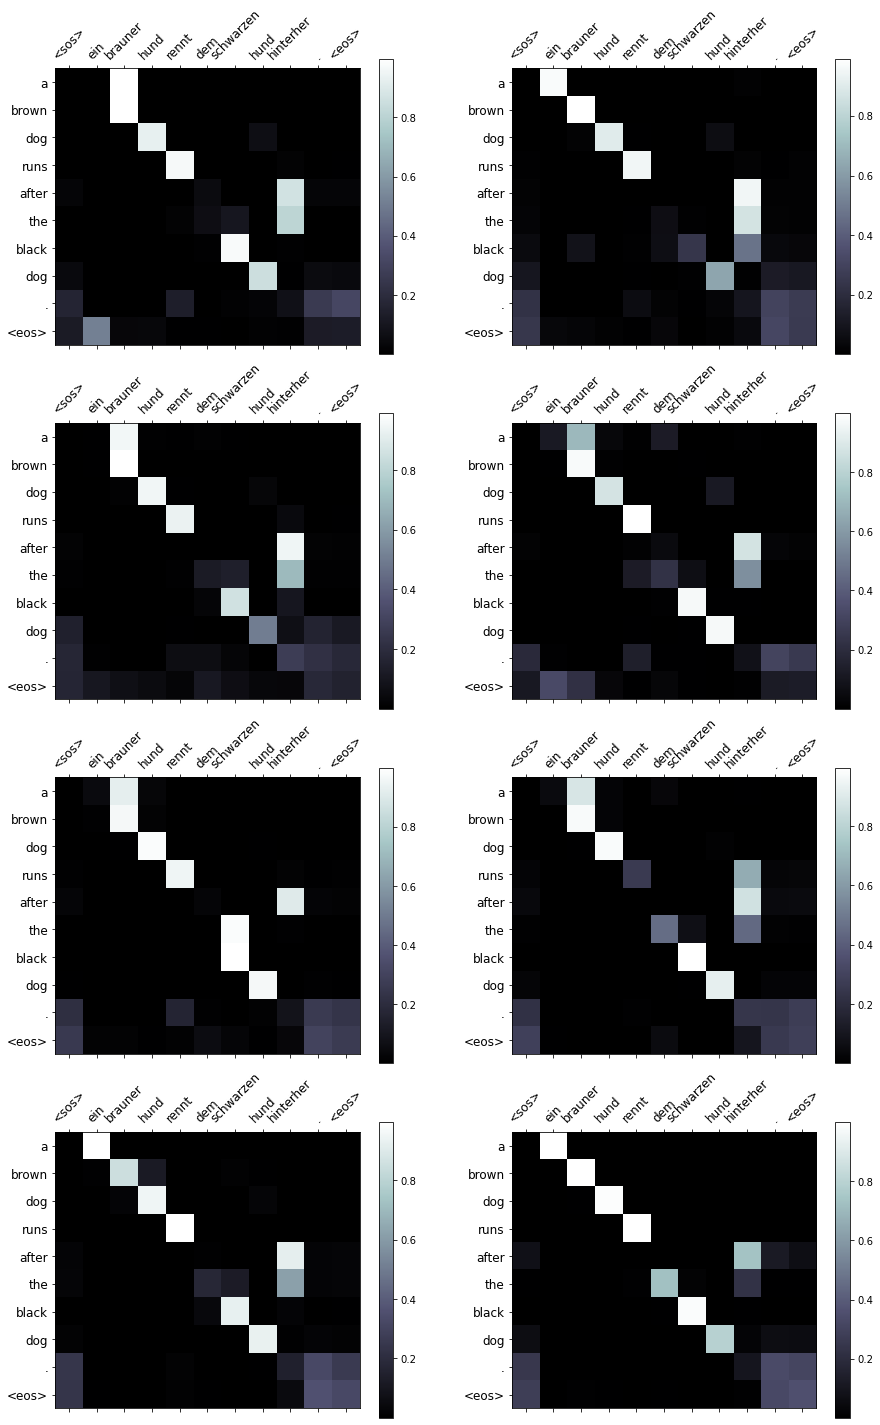

In [37]:
display_attention(src, translation, attention)

### BLEU(Bilingual Evaluation Understudy) Score계산

* 학습된 트랜스포머(transformer) 모델의 BLUE 스코어 계산

In [38]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        #vars : 객체의 __dict__ 속성 반환
        #{'src': ['ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.'], 
        # 'trg': ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.']}
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [39]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.50
